In [25]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
import googlemaps
from os import getenv

gmaps = googlemaps.Client(key=getenv("GMAPS_API_KEY"))
fasttext_vectors = KeyedVectors.load("fastvec.bin")



In [26]:
from typing import List
from app.models import Ride



def get_route_points(driver: Ride, finish_point: dict):
    """
    Fetch route points from Google Directions API.

    Args:
        driver (Ride): Driver's start location.
        finish_point (dict): Event location with 'latitude' and 'longitude'.

    Returns:
        list: A list of route points as (latitude, longitude).
    """
    driver_start = f"{driver["pickupLat"]},{driver["pickupLong"]}"
    event_location = f"{finish_point['latitude']},{finish_point['longitude']}"

    directions = gmaps.directions(
        driver_start,
        event_location,
        mode="driving"
    )

    route_points = [
        (step["start_location"]["lat"], step["start_location"]["lng"])
        for leg in directions[0]["legs"]
        for step in leg["steps"]
    ]
    # Include the final destination
    route_points.append((finish_point["latitude"], finish_point["longitude"]))

    return route_points


def calculate_haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float):
    """
    Calculate the Haversine distance between two points on the Earth.

    Args:
        lat1, lon1: Latitude and longitude of the first point.
        lat2, lon2: Latitude and longitude of the second point.

    Returns:
        float: Distance in kilometers.
    """
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c


def calculate_music_similarity(passengers: List[Ride], drivers: List[Ride]):
    """
    Calculate music similarity between users and drivers based on preferred genres.

    Args:
        passengers (List[Ride]): List of ride for passengers.
        drivers (List[Ride]): List of drivers.

    Returns:
        np.ndarray: Matrix of cosine similarities between users and drivers.
    """
    def get_playlist_embedding(preferred_genres):
        vectors = [fasttext_vectors[genre['name']] for genre in preferred_genres if genre['name'] in fasttext_vectors]
        return np.mean(vectors, axis=0) if vectors else np.zeros(fasttext_vectors.vector_size)
    user_embeddings = [get_playlist_embedding(passenger["user"]["preferredGenres"]) for passenger in passengers]
    driver_embeddings = [get_playlist_embedding(driver["user"]["preferredGenres"]) for driver in drivers]
    return cosine_similarity(user_embeddings, driver_embeddings)




In [27]:
def fetch_distance_matrix_with_route(users: List[Ride], drivers: List[Ride], batch_size=10):
    """
    Compute the distance matrix for users and drivers considering the driver's route.

    Args:
        users (list): List of users.
        drivers (list): List of drivers.
        batch_size (int): Batch size for distance computation.

    Returns:
        np.array: Distance matrix considering driver routes.
    """
    distance_matrix = np.full((len(users), len(drivers)), float('inf'))

    for driver_idx, driver in enumerate(drivers):
        # Fetch route points for the driver

        print("driver", driver)
        route_points = get_route_points(driver, {"latitude": driver["event"]["latitude"], "longitude": driver["event"]["longitude"]})


        for batch_start in range(0, len(users), batch_size):
            batch_users = users[batch_start:batch_start + batch_size]

            for user_idx, user in enumerate(batch_users):

                # Calculate the minimum distance from the user to any point on the driver's route
                min_distance = float('inf')
                print("user", user)
                for route_lat, route_lng in route_points:
                    distance = calculate_haversine_distance(
                        user["pickupLat"],
                        user["pickupLong"],
                        route_lat, route_lng
                    )
                    min_distance = min(min_distance, distance)

                # Convert to meters and update the distance matrix
                distance_matrix[batch_start + user_idx][driver_idx] = min_distance * 1000

    return distance_matrix

In [25]:
def assign_users_with_route(users, drivers, location_weight, music_weight):
    """
    Assign users to drivers based on proximity and music preferences, considering drivers' routes.

    Args:
        users (list): List of users with location, playlist, and driver eligibility.
        drivers (list): List of drivers with location, capacity, and route information.
        location_weight (float): Weight for location similarity.
        music_weight (float): Weight for music similarity.

    Returns:
        tuple: Updated users, remaining driver capacities, group distances.
    """
    while True:
        # Fetch the updated distance matrix considering routes
        distance_matrix = fetch_distance_matrix_with_route(users, drivers)
        
        # Calculate the music similarity matrix
        music_similarity_matrix = calculate_music_similarity(users, drivers)

        # Continue with the rest of the original logic...
        combined_scores = np.zeros_like(distance_matrix)
        driver_capacities = [driver["max_capacity"] for driver in drivers]

        group_distances = {driver["name"]: [] for driver in drivers}

        for user_idx, user in enumerate(users):
            for driver_idx, driver in enumerate(drivers):
                if distance_matrix[user_idx][driver_idx] <= driver["pickup_radius"] * 1000:
                    location_score = 1 - (distance_matrix[user_idx][driver_idx] / np.max(distance_matrix))
                    music_score = music_similarity_matrix[user_idx][driver_idx]
                    combined_scores[user_idx][driver_idx] = (
                        location_weight * location_score + music_weight * music_score
                    )

        user_distances = [
            (user_idx, min(distance_matrix[user_idx])) for user_idx in range(len(users))
        ]
        user_distances.sort(key=lambda x: x[1])

        outliers = []
        for user_idx, _ in user_distances:
            valid_drivers = [
                driver_idx for driver_idx, driver in enumerate(drivers)
                if distance_matrix[user_idx][driver_idx] <= driver["pickup_radius"] * 1000
            ]

            if valid_drivers:
                best_driver_idx = max(valid_drivers, key=lambda idx: combined_scores[user_idx][idx])
                if driver_capacities[best_driver_idx] > 0:
                    users[user_idx]["assigned_driver"] = drivers[best_driver_idx]["name"]
                    users[user_idx]["assigned_driver_index"] = best_driver_idx
                    driver_capacities[best_driver_idx] -= 1
                    group_distances[drivers[best_driver_idx]["name"]].append(
                        distance_matrix[user_idx][best_driver_idx] / 1000
                    )
                else:
                    users[user_idx]["assigned_driver"] = "outlier"
                    users[user_idx]["assigned_driver_index"] = -1
                    outliers.append(users[user_idx])
            else:
                users[user_idx]["assigned_driver"] = "outlier"
                users[user_idx]["assigned_driver_index"] = -1
                outliers.append(users[user_idx])

        if not outliers:
            break

        eligible_users = [
            user for user in users if user.get("can_be_driver", False) and user["assigned_driver"] == "outlier"
        ]

        if eligible_users:
            best_candidate = None
            max_coverage = 0

            for candidate in eligible_users:
                candidate_distances = fetch_distance_matrix_with_route([candidate], outliers)[0]
                coverage_count = sum(
                    1 for distance in candidate_distances if distance <= 2000
                )

                if coverage_count > max_coverage:
                    best_candidate = candidate
                    max_coverage = coverage_count

            if best_candidate and max_coverage > 0:
                new_driver = {
                    "id": len(drivers) + 1,
                    "name": f"NewDriver_{best_candidate['name']}",
                    "latitude": best_candidate["latitude"],
                    "longitude": best_candidate["longitude"],
                    "max_capacity": 3,
                    "pickup_radius": 4,
                    "playlist": best_candidate["playlist"],
                }
                drivers.append(new_driver)

                user_index = users.index(best_candidate)
                users.pop(user_index)

                distance_matrix = np.delete(distance_matrix, user_index, axis=0)
                music_similarity_matrix = np.delete(music_similarity_matrix, user_index, axis=0)

                best_candidate["assigned_driver"] = f"NewDriver_{best_candidate['name']}"
                best_candidate["assigned_driver_index"] = len(drivers) - 1

                new_driver_distances = fetch_distance_matrix_with_route(users, [new_driver])[:, 0]
                new_driver_music_similarity = calculate_music_similarity(users, [new_driver])[:, 0]
                distance_matrix = np.column_stack((distance_matrix, new_driver_distances))
                music_similarity_matrix = np.column_stack((music_similarity_matrix, new_driver_music_similarity))
            else:
                break
        else:
            break

    return users, driver_capacities, group_distances

In [28]:
from app.models import Event


def assign_users_with_route(passengers: List[Ride], drivers: List[Ride], final_point: Event, location_weight: float, music_weight: float):
    """
    Assign users to drivers based on proximity and music preferences, considering drivers' routes.

    Args:
        passengers (list): List of passengers (rides) with location, playlist, and driver eligibility.
        drivers (list): List of drivers (rides) with location, capacity, and route information.
        final_point (Event): Destination event with latitude and longitude.
        location_weight (float): Weight for location similarity.
        music_weight (float): Weight for music similarity.

    Returns:
        tuple: Updated passengers, remaining driver capacities, group distances.
    """
    def assign_from_start_point():
        """
        Assign passengers based on proximity to the driver's start point.
        """
        nonlocal passengers, drivers, distance_matrix, music_similarity_matrix

        combined_scores = np.zeros_like(distance_matrix)
        driver_capacities = [driver["vehicle"]["maxPassengers"] for driver in drivers]
        group_distances = {driver["user"]["firstName"]: [] for driver in drivers}

        for user_idx, user in enumerate(passengers):
            for driver_idx, driver in enumerate(drivers):
                if distance_matrix[user_idx][driver_idx] <= driver["pickupRadius"] * 1000:
                    location_score = 1 - (distance_matrix[user_idx][driver_idx] / np.max(distance_matrix))
                    music_score = music_similarity_matrix[user_idx][driver_idx]
                    combined_scores[user_idx][driver_idx] = (
                        location_weight * location_score + music_weight * music_score
                    )

        user_distances = [
            (user_idx, min(distance_matrix[user_idx])) for user_idx in range(len(passengers))
        ]
        user_distances.sort(key=lambda x: x[1])

        for user_idx, _ in user_distances:
            valid_drivers = [
                driver_idx for driver_idx, driver in enumerate(drivers)
                if distance_matrix[user_idx][driver_idx] <= driver["pickupRadius"] * 1000
            ]

            if valid_drivers:
                best_driver_idx = max(valid_drivers, key=lambda idx: combined_scores[user_idx][idx])
                if driver_capacities[best_driver_idx] > 0:
                    passengers[user_idx]["assigned_driver"] = drivers[best_driver_idx]  # Assign entire driver object
                    driver_capacities[best_driver_idx] -= 1
                    group_distances[drivers[best_driver_idx]["user"]["firstName"]].append(
                        distance_matrix[user_idx][best_driver_idx] / 1000
                    )
                else:
                    passengers[user_idx]["assigned_driver"] = None  # No driver assigned
            else:
                passengers[user_idx]["assigned_driver"] = None  # No driver assigned

        return driver_capacities, group_distances

    def assign_along_route():
        """
        Assign passengers along the route, considering proximity to route points.
        """
        nonlocal passengers, drivers

        for driver in drivers:
            route_points = get_route_points(driver, {"latitude": final_point["latitude"], "longitude": final_point['longitude']})
            for passenger in passengers:
                if passenger["assigned_driver"] is None:
                    for route_lat, route_lng in route_points:
                        distance = calculate_haversine_distance(
                            passenger["pickupLat"], passenger["pickupLong"],
                            route_lat, route_lng
                        )
                        if distance <= driver["pickupRadius"]:
                            passenger["assigned_driver"] = driver  # Assign entire driver object
                            break

    def promote_eligible_drivers():
        """
        Promote users marked as "can_be_driver" to drivers if they can resolve outliers.
        """
        nonlocal passengers, drivers
        outliers = [passenger for passenger in passengers if passenger["assigned_driver"] is None]
        eligible_users = [
            passenger for passenger in passengers if passenger["can_be_driver"] and passenger["assigned_driver"] is None
        ]

        for candidate in eligible_users:
            candidate_distances = fetch_distance_matrix_with_route([candidate], outliers)[0]
            coverage_count = sum(
                1 for distance in candidate_distances if distance <= 2000  # 2 km radius
            )

            if coverage_count > 0:
                new_driver = candidate
                drivers.append(new_driver)
                candidate["assigned_driver"] = new_driver  # Assign as driver object

                # Restart the whole algorithm after promoting a driver
                return True

        return False

    while True:
        # Initial distance and music similarity matrices
        distance_matrix = fetch_distance_matrix_with_route(passengers, drivers)
        music_similarity_matrix = calculate_music_similarity(passengers, drivers)

        # Step 1: Assign users from the start point
        driver_capacities, group_distances = assign_from_start_point()

        # Step 2: Assign remaining users along the route for drivers with available seats
        assign_along_route()

        # Step 3: Promote eligible drivers if outliers remain
        outliers = [passenger for passenger in passengers if passenger["assigned_driver"] is None]
        if not outliers:
            break

        if not promote_eligible_drivers():
            break

    return passengers, driver_capacities, group_distances


In [29]:
# users = [
#     # Users around Brussels
#     {"id": 1, "name": "Alice", "latitude": 50.8503, "longitude": 4.3517, "playlist": ["rock"], "can_be_driver": True},
#     {"id": 2, "name": "Bob", "latitude": 50.8476, "longitude": 4.3572, "playlist": ["rock", "pop-rock", "classic-rock"], "can_be_driver": False},
    
#     # Users around Ghent
#     {"id": 3, "name": "Charlie", "latitude": 51.0576, "longitude": 3.7304, "playlist": ["rap", "hip-hop"], "can_be_driver": False},
#     {"id": 4, "name": "Diana", "latitude": 51.0505, "longitude": 3.7222, "playlist": ["folk-pop", "jazz", "blues"], "can_be_driver": True},
    
#     # Users around Liège
#     {"id": 5, "name": "Eve", "latitude": 50.6400, "longitude": 5.5718, "playlist": ["pop", "neo-mellow", "latin"], "can_be_driver": True},
#     {"id": 6, "name": "Frank", "latitude": 50.6456, "longitude": 5.5624, "playlist": ["classical", "instrumental"], "can_be_driver": False},
    
#     # Users around Antwerp
#     {"id": 7, "name": "Grace", "latitude": 51.2167, "longitude": 4.4056, "playlist": ["hip-hop", "R&B"], "can_be_driver": False},
#     {"id": 8, "name": "Hank", "latitude": 51.2200, "longitude": 4.4000, "playlist": ["rock", "metal"], "can_be_driver": True},
    
#     # Other locations
#     {"id": 9, "name": "Isabelle", "latitude": 50.9333, "longitude": 4.0333, "playlist": ["pop", "electro-pop"], "can_be_driver": False},  # Aalst
#     {"id": 10, "name": "Jack", "latitude": 50.8820, "longitude": 4.7089, "playlist": ["jazz", "swing"], "can_be_driver": False},  # Leuven
#     {"id": 11, "name": "Karen", "latitude": 50.4796, "longitude": 4.8674, "playlist": ["rock", "indie"], "can_be_driver": True},  # Namur
#     {"id": 12, "name": "Leo", "latitude": 50.5039, "longitude": 4.4699, "playlist": ["folk", "acoustic"], "can_be_driver": True},  # Charleroi
#        # New passengers near Brussels
#     {"id": 13, "name": "Maggie", "latitude": 50.8600, "longitude": 4.3700, "playlist": ["electro-pop", "synth"], "can_be_driver": False},
#     {"id": 14, "name": "Nina", "latitude": 50.8700, "longitude": 4.3400, "playlist": ["classical", "piano"], "can_be_driver": False},
    
#     # New passengers near Ghent
#     {"id": 15, "name": "Oliver", "latitude": 51.0600, "longitude": 3.7200, "playlist": ["EDM", "techno"], "can_be_driver": True},
#     {"id": 16, "name": "Patrick", "latitude": 51.0650, "longitude": 3.7100, "playlist": ["folk", "country"], "can_be_driver": False},
    
#     # New passengers near Liège
#     {"id": 17, "name": "Quincy", "latitude": 50.6500, "longitude": 5.5700, "playlist": ["jazz", "funk"], "can_be_driver": False},
#     {"id": 18, "name": "Rachel", "latitude": 50.6405, "longitude": 5.5800, "playlist": ["pop", "latin"], "can_be_driver": True},
    
#     # New passengers near Antwerp
#     {"id": 19, "name": "Sam", "latitude": 51.2200, "longitude": 4.4100, "playlist": ["hip-hop", "trap"], "can_be_driver": False},
#     {"id": 20, "name": "Tina", "latitude": 51.2150, "longitude": 4.4200, "playlist": ["rock", "alternative"], "can_be_driver": False},
    
#     # Passengers in other locations
#     {"id": 21, "name": "Uma", "latitude": 50.9000, "longitude": 4.0000, "playlist": ["R&B", "soul"], "can_be_driver": False},  # Near Aalst
#     {"id": 22, "name": "Victor", "latitude": 50.5000, "longitude": 4.7000, "playlist": ["metal", "hard-rock"], "can_be_driver": True},  # Near Namur
#     {"id": 23, "name": "Wendy", "latitude": 50.5200, "longitude": 4.5000, "playlist": ["folk", "acoustic"], "can_be_driver": False},  # Near Charleroi
#     {"id": 24, "name": "Xander", "latitude": 51.0000, "longitude": 4.0000, "playlist": ["electronic", "dubstep"], "can_be_driver": True},  # Between Ghent and Brussels
#     {"id": 25, "name": "Yara", "latitude": 50.7500, "longitude": 5.8000, "playlist": ["pop", "dance"], "can_be_driver": False},  # Near Liège
#     {"id": 26, "name": "Zack", "latitude": 51.1500, "longitude": 4.3000, "playlist": ["indie", "alternative"], "can_be_driver": False},  # Near Antwerp
# ]


# drivers = [
#     {"id": 1, "name": "Driver1", "latitude": 50.8501, "longitude": 4.3517, "max_capacity": 4, "pickup_radius": 4, "playlist": ["rock"]},  # Brussels
#     {"id": 2, "name": "Driver2", "latitude": 51.0543, "longitude": 3.7174, "max_capacity": 4, "pickup_radius": 4, "playlist": ["pop", "electronic"]},  # Ghent
#     {"id": 3, "name": "Driver3", "latitude": 50.6451, "longitude": 5.5734, "max_capacity": 4, "pickup_radius": 4, "playlist": ["jazz", "blues"]},  # Liège
#     {"id": 4, "name": "Driver4", "latitude": 51.2194, "longitude": 4.4025, "max_capacity": 4, "pickup_radius": 4, "playlist": ["hip-hop", "rap"]},  # Antwerp
# ]

import json


with open('example.json', 'r') as json_file:
    rides_data = json.load(json_file)['rides']

def filter_rides(rides):
    drivers = [ride for ride in rides if ride["driver"] is True]
    passengers = [ride for ride in rides if ride["driver"] is False]
    return drivers, passengers

# Get filtered results
drivers, passengers = filter_rides(rides_data)

print(passengers)


location_weight = 0.1
music_weight = 0.9
finish_point = {"latitude": drivers[0]['event']["latitude"], "longitude": drivers[0]['event']["longitude"]} 
passengers, remaining_capacities, group_distances = assign_users_with_route(passengers, drivers, finish_point,location_weight, music_weight)

print("Updated Users:", passengers)
print("Remaining Capacities:", remaining_capacities)
print("Group Distances:", group_distances)



[{'id': 2, 'eventId': 101, 'isDriver': False, 'userId': 2, 'vehicleId': None, 'pickupRadius': 10, 'pickupLong': 4.4724, 'pickupLat': 50.8804, 'pickupSequence': 2, 'driverId': 1, 'can_be_driver': False, 'vehicle': None, 'user': {'id': 2, 'firstName': 'Alice', 'lastName': 'Johnson', 'email': 'alice.johnson@example.com', 'address': '789 Zaventem Road', 'city': 'Zaventem', 'isSmoking': False, 'isTalkative': False, 'seatingPreference': True, 'preferredGenres': [{'id': 3, 'name': 'Pop'}, {'id': 4, 'name': 'Classical'}]}, 'event': {'id': 101, 'title': 'Music Festival in Antwerp', 'description': 'An exciting music festival in Antwerp', 'startDate': '2025-07-01', 'endDate': '2025-07-03', 'address': 'Central Park, Antwerp', 'registerDeadline': '2025-06-15', 'longitude': 4.4025, 'latitude': 51.2194}}, {'id': 3, 'eventId': 101, 'isDriver': False, 'userId': 3, 'vehicleId': 1, 'pickupRadius': 10, 'pickupLong': 4.4846, 'pickupLat': 51.0267, 'pickupSequence': 3, 'driverId': 1, 'can_be_driver': True, '

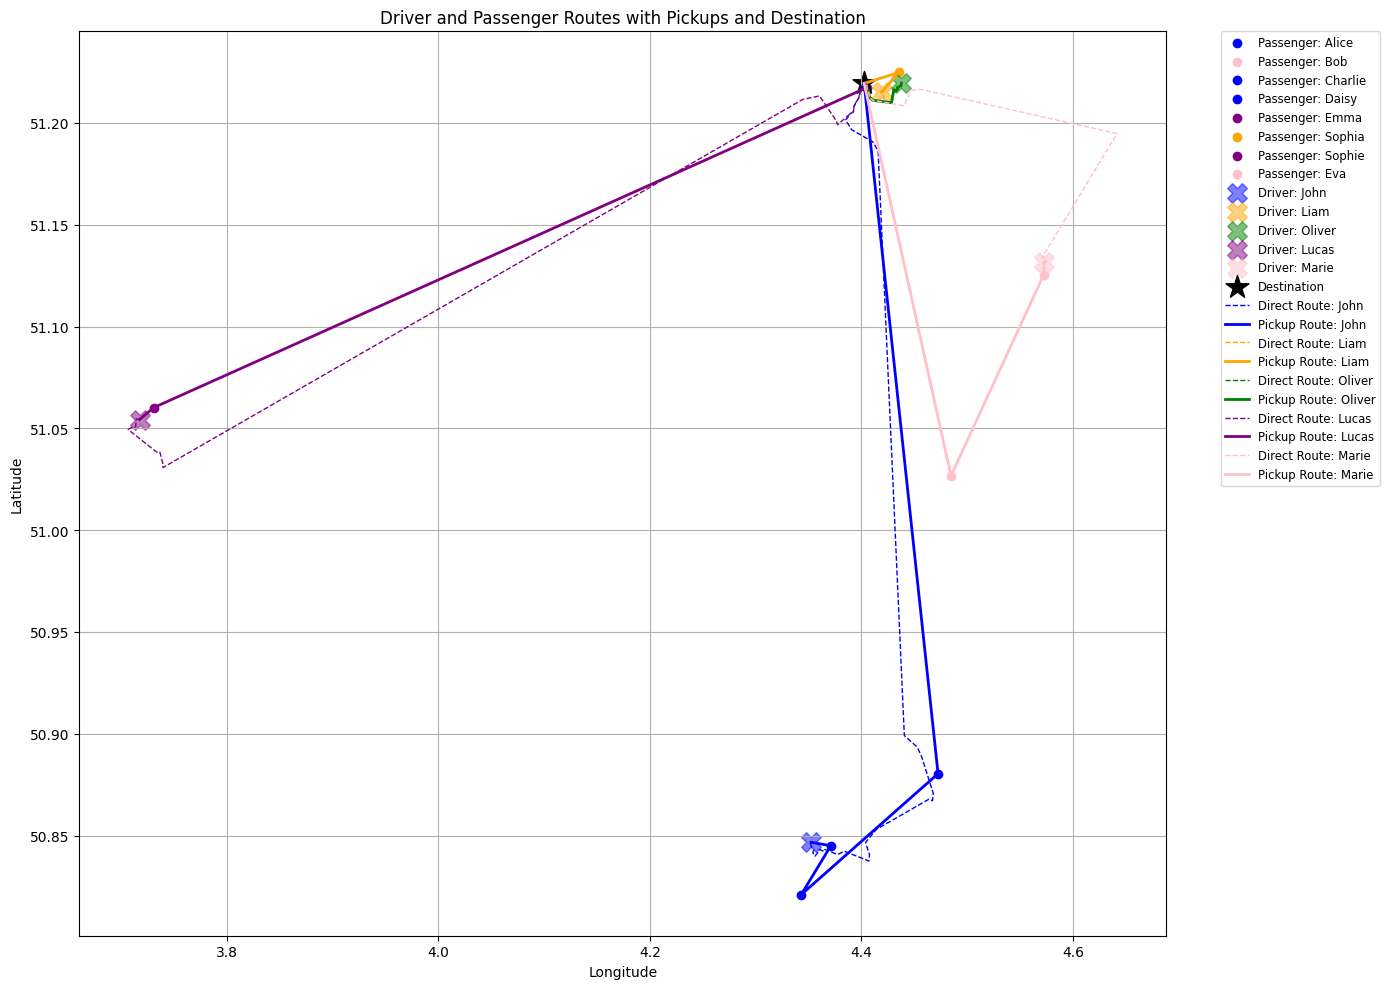

In [30]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
def plot_clusters_with_outliers(users, drivers, destination, direct_routes, pickup_routes):
    """
    Plot users and drivers, showing direct and pickup-inclusive routes to the destination.
    """
    # Define colors for drivers
    colors = ['blue', 'orange', 'green', 'purple', 'pink', 'cyan', 'yellow', 'brown', 'lime', 'teal']
    color_map = {i: colors[i % len(colors)] for i in range(len(drivers))}

    # Set plot size
    plt.figure(figsize=(14, 10))

    # Plot passengers
    for user in users:
        if user['assigned_driver'] is None:
            plt.scatter(
                user['pickupLong'], user['pickupLat'],
                c='red', label=f"Passenger: {user['user']['firstName']} (Unassigned)"
            )
        else:
            assigned_driver = user['assigned_driver']
            driver_index = next((i for i, driver in enumerate(drivers) if driver == assigned_driver), None)
            if driver_index is not None:
                plt.scatter(
                    user['pickupLong'], user['pickupLat'],
                    c=color_map[driver_index],
                    label=f"Passenger: {user['user']['firstName']}"
                )

    # Plot drivers
    for i, driver in enumerate(drivers):
        plt.scatter(
            driver['pickupLong'], driver['pickupLat'],
            c=color_map[i], marker='X', s=200, alpha=0.5,
            label=f"Driver: {driver['user']['firstName']}"
        )

    # Plot destination
    plt.scatter(
        destination['longitude'], destination['latitude'],
        c='black', marker='*', s=300, label="Destination"
    )

    # Plot routes
    for i, (direct_route, pickup_route) in enumerate(zip(direct_routes, pickup_routes)):
        # Direct route
        direct_lats, direct_lngs = zip(*direct_route)
        plt.plot(direct_lngs, direct_lats, color=color_map[i], linestyle='--', linewidth=1, label=f"Direct Route: {drivers[i]['user']['firstName']}")

        # Pickup-inclusive route
        pickup_lats, pickup_lngs = zip(*pickup_route)
        plt.plot(pickup_lngs, pickup_lats, color=color_map[i], linestyle='-', linewidth=2, label=f"Pickup Route: {drivers[i]['user']['firstName']}")

    # Add labels and title
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Driver and Passenger Routes with Pickups and Destination")
    plt.grid(True)

    # Add legend
    plt.legend(loc="upper left", fontsize='small', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()


def calculate_driver_routes(drivers, passengers, destination):
    """
    Calculate both direct and pickup-inclusive routes for all drivers.

    Args:
        drivers (list): List of drivers.
        passengers (list): List of passengers.
        destination (dict): Destination point with latitude and longitude.

    Returns:
        tuple: Two lists of routes (direct routes, pickup-inclusive routes).
    """
    direct_routes = []
    pickup_routes = []

    for driver in drivers:
        # Direct route to destination
        direct_route_points = get_route_points(driver, destination)
        direct_routes.append(direct_route_points)

        # Pickup-inclusive route
        assigned_passengers = [
            passenger for passenger in passengers if passenger['assigned_driver'] == driver
        ]
        if assigned_passengers:
            # Sort passengers by proximity to driver for better routing
            assigned_passengers.sort(
                key=lambda p: calculate_haversine_distance(
                    driver['pickupLat'], driver['pickupLong'],
                    p['pickupLat'], p['pickupLong']
                )
            )
            # Add passenger pickup locations
            pickup_points = [(p['pickupLat'], p['pickupLong']) for p in assigned_passengers]
            route_with_pickups = [(driver['pickupLat'], driver['pickupLong'])] + pickup_points
            route_with_pickups += [(destination['latitude'], destination['longitude'])]
            pickup_routes.append(route_with_pickups)
        else:
            # No pickups; fallback to direct route
            pickup_routes.append(direct_route_points)

    return direct_routes, pickup_routes
# Calculate routes
direct_routes, pickup_routes = calculate_driver_routes(drivers, passengers, finish_point)

# Visualize with routes
plot_clusters_with_outliers(passengers, drivers, finish_point, direct_routes, pickup_routes)

In [47]:
from datetime import datetime, timedelta

def calculate_time_between_points(point1, point2, gmaps):
    """
    Calculate travel time between two points using Google Distance Matrix API.
    """
    response = gmaps.distance_matrix(
        origins=[(point1["latitude"], point1["longitude"])],
        destinations=[(point2["latitude"], point2["longitude"])],
        mode="driving"
    )
    if response["rows"][0]["elements"][0]["status"] == "OK":
        return response["rows"][0]["elements"][0]["duration"]["value"]  # Time in seconds
    return float('inf')  # Return a large value if no route found

def assign_start_times_to_drivers_and_passengers(drivers_data, event_start_time, gmaps):
    """
    Assign start times for drivers and passengers based on their routes and the provided structure.

    Args:
        drivers_data (list): List of drivers with assigned passengers.
        event_start_time (datetime): Event start time.
        gmaps: Google Maps API client.

    Returns:
        list: List with updated start times for drivers and their passengers.
    """
    for driver_data in drivers_data:
        driver = {
            "latitude": driver_data["pickupLat"],
            "longitude": driver_data["pickupLong"]
        }
        passengers = driver_data["assidnedPassengers"]

        # Initialize variables for travel time calculation
        total_travel_time = 0
        current_time = event_start_time

        # Assign journey start times for passengers
        for idx, passenger in enumerate(passengers):
            if idx == 0:
                # Travel time from driver to the first passenger
                travel_time = calculate_time_between_points(
                    driver, 
                    {"latitude": passenger["pickupLat"], "longitude": passenger["pickupLong"]}, 
                    gmaps
                )
            else:
                # Travel time between consecutive passengers
                previous_passenger = passengers[idx - 1]
                travel_time = calculate_time_between_points(
                    {"latitude": previous_passenger["pickupLat"], "longitude": previous_passenger["pickupLong"]},
                    {"latitude": passenger["pickupLat"], "longitude": passenger["pickupLong"]},
                    gmaps
                )

            # Update the current time and assign to the passenger
            current_time -= timedelta(seconds=travel_time + 300)  # Add 5 minutes wait time
            passenger["pickupSequence"] = idx + 1
            passenger["startDateTime"] = current_time.strftime("%H:%M")

        # Add travel time from the last passenger to the event location
        last_passenger = passengers[-1] if passengers else driver
        travel_time_to_event = calculate_time_between_points(
            {"latitude": last_passenger["pickupLat"], "longitude": last_passenger["pickupLong"]},
            {"latitude": driver_data["event"]["latitude"], "longitude": driver_data["event"]["longitude"]},
            gmaps
        )
        total_travel_time += travel_time_to_event

        # Adjust driver's start time based on the total travel time
        driver_start_time = current_time - timedelta(seconds=travel_time_to_event)
        driver_data["startDateTime"] = driver_start_time.strftime("%H:%M")

    return drivers_data


In [48]:
import json


with open('drivers_groups.json', 'r') as json_file:
    rides_data = json.load(json_file)

event_start_time = datetime(2025, 1, 13, 18, 0)

updated_rides = assign_start_times_to_drivers_and_passengers(rides_data, event_start_time, gmaps)


print(updated_rides)

[{'id': 1, 'eventId': 101, 'isDriver': True, 'userId': 1, 'vehicleId': 1, 'pickupRadius': 10, 'pickupLong': 4.3524, 'pickupLat': 50.8467, 'pickupSequence': None, 'journeyStartTime': '16:32', 'driverId': None, 'can_be_driver': False, 'vehicle': {'id': 1, 'brand': 'Toyota', 'model': 'Corolla', 'color': 'Blue', 'plate': 'ABC-123', 'maxPassengers': 3}, 'user': {'id': 1, 'firstName': 'John', 'lastName': 'Doe', 'email': 'john.doe@example.com', 'address': '123 Main Street', 'city': 'Brussels', 'isSmoking': False, 'isTalkative': True, 'seatingPreference': True, 'preferredGenres': [{'id': 1, 'name': 'Rock'}, {'id': 2, 'name': 'Jazz'}]}, 'event': {'id': 101, 'title': 'Music Festival in Antwerp', 'description': 'An exciting music festival in Antwerp', 'startDate': '2025-07-01', 'endDate': '2025-07-03', 'address': 'Central Park, Antwerp', 'registerDeadline': '2025-06-15', 'longitude': 4.4025, 'latitude': 51.2194}, 'assidnedPassengers': [{'id': 2, 'eventId': 101, 'isDriver': False, 'userId': 2, 've

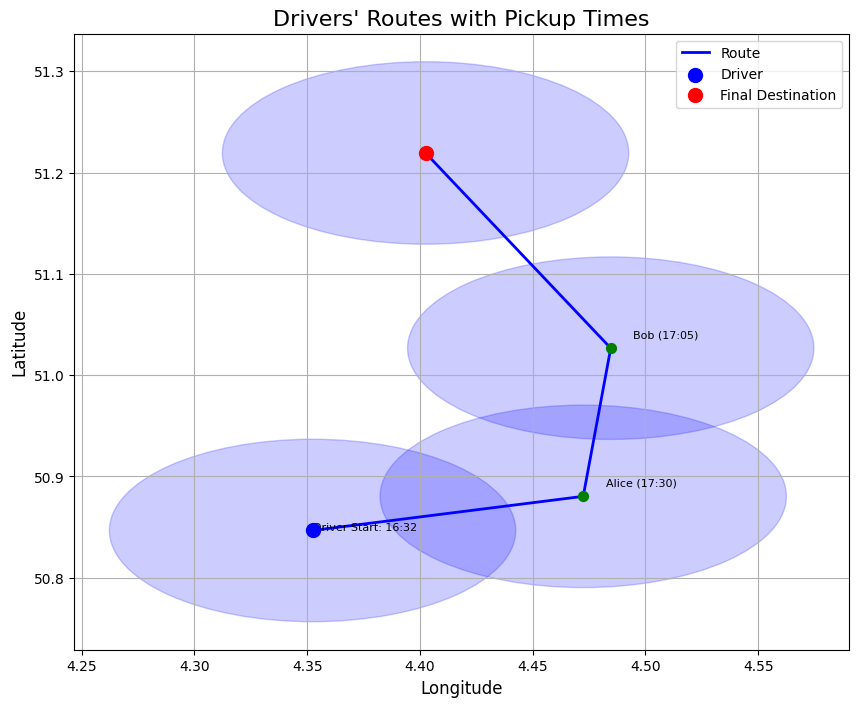

In [49]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


def plot_with_start_times(driver_data_list):
    """
    Plot the drivers' routes, passengers, and their assigned start times.

    Args:
        driver_data_list (list): List of driver data including passengers, route, and start times.
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    for driver_data in driver_data_list:
        # Extract driver and event details
        driver = {
            "latitude": driver_data["pickupLat"],
            "longitude": driver_data["pickupLong"],
            "start_time": driver_data.get("startDateTime"),
            "pickup_radius": driver_data["pickupRadius"]
        }
        event = {
            "latitude": driver_data["event"]["latitude"],
            "longitude": driver_data["event"]["longitude"]
        }

        # Convert pickup radius to degrees (approximation, assuming 1 degree = 111 km)
        radius_deg = driver["pickup_radius"] / 111

        # Plot route points as a line
        route_points = [(driver_data["pickupLat"], driver_data["pickupLong"])] + [
            (p["pickupLat"], p["pickupLong"]) for p in driver_data["assidnedPassengers"]
        ] + [(event["latitude"], event["longitude"])]

        route_lats, route_lngs = zip(*route_points)
        ax.plot(route_lngs, route_lats, color="blue", linewidth=2, label="Route")

        # Add semi-transparent circles for the pickup radius
        for lat, lng in route_points:
            circle = Circle((lng, lat), radius_deg, color="blue", alpha=0.2)
            ax.add_patch(circle)

        # Plot driver start point with time
        ax.scatter(driver["longitude"], driver["latitude"], color="blue", s=100, label="Driver", zorder=5)
        if driver["start_time"]:
            ax.text(driver["longitude"], driver["latitude"], f"Driver Start: {driver['start_time']}", fontsize=8)

        # Plot assigned passengers with pickup times
        for passenger in driver_data["assidnedPassengers"]:
            ax.scatter(
                passenger["pickupLong"], passenger["pickupLat"],
                color="green", s=50, zorder=5
            )
            passenger_time = passenger.get("startDateTime")
            if passenger_time:
                ax.text(
                    passenger["pickupLong"] + 0.01, passenger["pickupLat"] + 0.01,
                    f"{passenger['user']['firstName']} ({passenger_time})",
                    fontsize=8
                )

        # Add final destination
        ax.scatter(
            event["longitude"], event["latitude"],
            color="red", s=100, label="Final Destination", zorder=5
        )

    # Formatting the plot
    ax.set_title("Drivers' Routes with Pickup Times", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    ax.legend(loc="upper right", fontsize=10)
    ax.grid(True)
    plt.show()


plot_with_start_times(updated_rides)
